In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import reverse_geocoder as rg
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars
%matplotlib inline

In [2]:
# Reading main database from scrubbed_data
df_aliens = pd.read_csv('../raw_data/scrubbed.csv', low_memory=False)

# Cleaning the locations portion of the original alien scrubbed dataset

## Reading and cleaning

In [3]:
df_aliens.head()

datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

   longitude   
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

In [4]:
status(df_aliens)

variable  q_nan     p_nan  q_zeros  p_zeros  unique     type
0               datetime      0  0.000000        0      0.0   69586   object
1                   city      0  0.000000        0      0.0   19900   object
2                  state   5797  0.072163        0      0.0      67   object
3                country   9670  0.120375        0      0.0       5   object
4                  shape   1932  0.024050        0      0.0      29   object
5     duration (seconds)      0  0.000000        0      0.0     537   object
6   duration (hours/min)      0  0.000000        0      0.0    8349   object
7               comments     15  0.000187        0      0.0   79997   object
8            date posted      0  0.000000        0      0.0     317   object
9               latitude      0  0.000000        0      0.0   18445   object
10            longitude       0  0.000000        0      0.0   19455  float64

In [5]:
df_aliens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


In [6]:
# Checking where are the wierd values inside latitude

df_aliens[df_aliens['latitude'].str.contains('[A-Za-z]', na=False)]

datetime                          city state country      shape  \
43782  5/22/1974 05:30  mescalero indian reservation    nm     NaN  rectangle   

      duration (seconds) duration (hours/min)  \
43782                180            two hours   

                                                comments date posted  \
43782  Huge rectangular object emmitting intense whit...   4/18/2012   

         latitude  longitude   
43782  33q.200088 -105.624152

In [7]:
# Changing the wierd values inside latitude to float

df_aliens = df_aliens.drop([43782])
df_aliens = df_aliens.reset_index(drop=True)
df_aliens['latitude'] = df_aliens['latitude'].dropna(axis=0)
df_aliens['longitude'] =df_aliens['longitude '].dropna(axis=0)
df_aliens['latitude'] = df_aliens['latitude'].astype(float)
df_aliens['longitude'] = df_aliens['longitude '].astype(float)

## Reverse geocode

In [8]:
import reverse_geocoder as rg
coordinates = list(zip(df_aliens['latitude'], df_aliens['longitude']))
results = rg.search(coordinates)

Loading formatted geocoded file...


In [9]:
df_aliens.loc[1,['latitude','longitude ','city','state','country']]

latitude          29.38421
longitude       -98.581082
city          lackland afb
state                   tx
country                NaN
Name: 1, dtype: object

In [10]:
results_df = pd.DataFrame(results)
df_aliens['country_c']=results_df['cc']
df_aliens['city_c']=results_df['name']
df_aliens['state_c'] = results_df['admin1']

In [11]:
df_aliens[['country','country_c','state','state_c','city','city_c']]

country country_c state     state_c                  city  \
0          us        US    tx       Texas            san marcos   
1         NaN        US    tx       Texas          lackland afb   
2          gb        GB   NaN     England  chester (uk/england)   
3          us        US    tx       Texas                  edna   
4          us        US    hi      Hawaii               kaneohe   
...       ...       ...   ...         ...                   ...   
80326      us        US    tn   Tennessee             nashville   
80327      us        US    id       Idaho                 boise   
80328      us        US    ca  California                  napa   
80329      us        US    va    Virginia                vienna   
80330      us        US    ok    Oklahoma                edmond   

                        city_c  
0                   San Marcos  
1      Lackland Air Force Base  
2                       Blacon  
3                         Edna  
4                     Kane'ohe  
...                        ...  
80326                Nashville  
80327                    Boise  
80328                     Napa  
80329                   Vienna  
80330                   Edmond  

[80331 rows x 6 columns]

In [12]:
# Checking for nan or '' values in state_c
df_aliens[ (df_aliens['state_c'].notnull()) & (df_aliens['state_c']=='') ].index

Int64Index([ 1740,  8882, 14027, 16546, 16695, 17657, 18179, 21441, 24959,
            25091, 25817, 26926, 27468, 27985, 28264, 30356, 31599, 32978,
            34394, 35978, 36057, 36595, 36987, 37793, 37976, 38013, 38625,
            39579, 39916, 40978, 43021, 43580, 44029, 47671, 49271, 49353,
            49934, 50003, 50793, 51023, 53028, 53148, 53286, 53969, 54405,
            63778, 64158, 64756, 65023, 65321, 66051, 67764, 69752, 70395,
            72406, 72566, 74541, 75081, 75195, 75528, 76380, 76860],
           dtype='int64')

In [13]:
# Replace empty values in state_c with the city name
df_aliens['state_c'] = df_aliens['state_c'].replace({'': np.nan})
df_aliens['state_c'] = df_aliens['state_c'].fillna(df_aliens['city_c'])

In [14]:
# Checking for nan or '' values in country_c
df_aliens[ (df_aliens['country_c'].notnull()) & (df_aliens['country_c']=='') ].index # not a problem!

Int64Index([], dtype='int64')

In [15]:
# Checking for nan or '' values in city_c
df_aliens[ (df_aliens['city_c'].notnull()) & (df_aliens['city_c']=='') ].index # not a problem!

Int64Index([], dtype='int64')

## Drop the original city, state and country values

In [16]:
df_aliens_filtered = df_aliens.drop(columns = ['longitude ', 'comments', 'city', 'state', 'country'])

In [17]:
# Keeping only US cities/States
df_aliens_filtered = df_aliens_filtered[df_aliens_filtered['country_c'] == 'US']

## End product

In [18]:
df_aliens_filtered.head()

datetime     shape duration (seconds) duration (hours/min)  \
0  10/10/1949 20:30  cylinder               2700           45 minutes   
1  10/10/1949 21:00     light               7200              1-2 hrs   
3  10/10/1956 21:00    circle                 20             1/2 hour   
4  10/10/1960 20:00     light                900           15 minutes   
5  10/10/1961 19:00    sphere                300            5 minutes   

  date posted   latitude   longitude country_c                   city_c  \
0   4/27/2004  29.883056  -97.941111        US               San Marcos   
1  12/16/2005  29.384210  -98.581082        US  Lackland Air Force Base   
3   1/17/2004  28.978333  -96.645833        US                     Edna   
4   1/22/2004  21.418056 -157.803611        US                 Kane'ohe   
5   4/27/2007  36.595000  -82.188889        US                  Bristol   

     state_c  
0      Texas  
1      Texas  
3      Texas  
4     Hawaii  
5  Tennessee

# Cleaning the worldcities location/population dataset - NOT IN USE

In [19]:
# Reading locations datbase
df_loc = pd.read_csv('../raw_data/worldcities.csv', low_memory=False)

In [20]:
df_loc.head()

city   city_ascii      lat       lng        country iso2 iso3  \
0        Tokyo        Tokyo  35.6850  139.7514          Japan   JP  JPN   
1     New York     New York  40.6943  -73.9249  United States   US  USA   
2  Mexico City  Mexico City  19.4424  -99.1310         Mexico   MX  MEX   
3       Mumbai       Mumbai  19.0170   72.8570          India   IN  IND   
4    São Paulo    Sao Paulo -23.5587  -46.6250         Brazil   BR  BRA   

         admin_name  capital  population          id  
0             Tōkyō  primary  35676000.0  1392685764  
1          New York      NaN  19354922.0  1840034016  
2  Ciudad de México  primary  19028000.0  1484247881  
3       Mahārāshtra    admin  18978000.0  1356226629  
4         São Paulo    admin  18845000.0  1076532519

In [21]:
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493 entries, 0 to 15492
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        15493 non-null  object 
 1   city_ascii  15493 non-null  object 
 2   lat         15493 non-null  float64
 3   lng         15493 non-null  float64
 4   country     15493 non-null  object 
 5   iso2        15462 non-null  object 
 6   iso3        15493 non-null  object 
 7   admin_name  15302 non-null  object 
 8   capital     5246 non-null   object 
 9   population  13808 non-null  float64
 10  id          15493 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 1.3+ MB


In [22]:
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15493 entries, 0 to 15492
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        15493 non-null  object 
 1   city_ascii  15493 non-null  object 
 2   lat         15493 non-null  float64
 3   lng         15493 non-null  float64
 4   country     15493 non-null  object 
 5   iso2        15462 non-null  object 
 6   iso3        15493 non-null  object 
 7   admin_name  15302 non-null  object 
 8   capital     5246 non-null   object 
 9   population  13808 non-null  float64
 10  id          15493 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 1.3+ MB


In [23]:
# Checking for nan or '' values in iso2
df_loc[ (df_loc['iso2'].notnull()) & (df_loc['iso2']=='') ].index # not a probelm!

Int64Index([], dtype='int64')

In [24]:
# Checking for nan or '' values in population
df_loc[ (df_loc['population'].notnull()) & (df_loc['population']=='') ].index # not a probelm!

Int64Index([], dtype='int64')

In [25]:
# Dropping columns city, city_ascii, country, iso3, admin_name, capital, id
df_loc_filtered = df_loc.drop(['lat', 'lng','city_ascii', 'country', 'iso3', 'admin_name', 'capital', 'id'],axis=1)

In [26]:
df_loc_filtered = df_loc_filtered.rename(columns={
    'iso2':'country_p'})
df_loc_filtered.head() # This is the cleaned locations database of all US cities

city country_p  population
0        Tokyo        JP  35676000.0
1     New York        US  19354922.0
2  Mexico City        MX  19028000.0
3       Mumbai        IN  18978000.0
4    São Paulo        BR  18845000.0

In [27]:
df_loc_filtered.shape

(15493, 3)

# Cleaning the US cities database

## Reading and cleaning

In [28]:
# Reading locations datbase
df_us_cities = pd.read_csv('../raw_data/uscities.csv', low_memory=False)

#df_us_cities= df_us_cities[['State', 'City', 'Population']].rename(columns = {'State': 'state_c','City':'city_c'})
df_us_cities.head()

city   city_ascii state_id  state_name  county_fips  county_name  \
0     New York     New York       NY    New York        36061     New York   
1  Los Angeles  Los Angeles       CA  California         6037  Los Angeles   
2      Chicago      Chicago       IL    Illinois        17031         Cook   
3        Miami        Miami       FL     Florida        12086   Miami-Dade   
4       Dallas       Dallas       TX       Texas        48113       Dallas   

       lat       lng  population  density   source  military  incorporated  \
0  40.6943  -73.9249    18713220    10715  polygon     False          True   
1  34.1139 -118.4068    12750807     3276  polygon     False          True   
2  41.8373  -87.6862     8604203     4574  polygon     False          True   
3  25.7839  -80.2102     6445545     5019  polygon     False          True   
4  32.7936  -96.7662     5743938     1526  polygon     False          True   

              timezone  ranking  \
0     America/New_York        1   
1  America/Los_Angeles        1   
2      America/Chicago        1   
3     America/New_York        1   
4      America/Chicago        1   

                                                zips          id  
0  11229 11226 11225 11224 11222 11221 11220 1138...  1840034016  
1  90291 90293 90292 91316 91311 90037 90031 9000...  1840020491  
2  60018 60649 60641 60640 60643 60642 60645 6064...  1840000494  
3  33129 33125 33126 33127 33128 33149 33144 3314...  1840015149  
4  75287 75098 75233 75254 75251 75252 75253 7503...  1840019440

# Ploting

In [29]:
import folium
from folium.plugins import HeatMap

center_location = 29.8830556, -97.9411111
m = folium.Map(location=center_location, control_scale=True, zoom_start=3)

location_df = df_aliens_filtered[['latitude','longitude']]
population_df = df_us_cities[['lat','lng','population']]
population_df = population_df[population_df['population']>100000].sort_values(by =['population'])

location_df['count'] = 1
heatmap_data = location_df.groupby(['latitude', 'longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)

for i in range(0,len(population_df)):
    folium.Circle(
      location=[population_df.iloc[i]['lat'], population_df.iloc[i]['lng']],
      radius=float(population_df.iloc[i]['population'])*(1/100),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

m

<ipython-input-29-804234183b28>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['count'] = 1


In [30]:
center_location = 29.8830556, -97.9411111
m = folium.Map(location=center_location, control_scale=True, zoom_start=3)

location_df = df_aliens_filtered[['latitude','longitude', 'city_c']]
population_df = df_us_cities[['lat','lng','population']]
population_df = population_df[population_df['population']>10000].sort_values(by=['population'])

for i in range(0,len(location_df.head(1000))):
    folium.Marker(
      location=[location_df.iloc[i]['latitude'], location_df.iloc[i]['longitude']],
      popup=location_df.iloc[i]['city_c'],
   ).add_to(m)


for i in range(0,len(population_df.head(10000))):
    folium.Circle(
      location=[population_df.iloc[i]['lat'], population_df.iloc[i]['lng']],
      radius=float(population_df.iloc[i]['population'])*(1/50),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)

m

In [31]:
center_location = 29.8830556, -97.9411111
m = folium.Map(location=center_location, control_scale=True, zoom_start=3)

location_df = df_aliens_filtered[['latitude','longitude']]
population_df = df_us_cities[['lat','lng','population','city', 'military']]
population_df = population_df[population_df['military']==True]

location_df['count'] = 1
heatmap_data = location_df.groupby(['latitude', 'longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)

for i in range(0,len(population_df)):
    folium.Marker(
      location=[population_df.iloc[i]['lat'], population_df.iloc[i]['lng']],
      popup=population_df.iloc[i]['city'],
   ).add_to(m)

m

<ipython-input-31-a8e4fde1f380>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_df['count'] = 1


In [32]:
df_aliens_filtered.head()

datetime     shape duration (seconds) duration (hours/min)  \
0  10/10/1949 20:30  cylinder               2700           45 minutes   
1  10/10/1949 21:00     light               7200              1-2 hrs   
3  10/10/1956 21:00    circle                 20             1/2 hour   
4  10/10/1960 20:00     light                900           15 minutes   
5  10/10/1961 19:00    sphere                300            5 minutes   

  date posted   latitude   longitude country_c                   city_c  \
0   4/27/2004  29.883056  -97.941111        US               San Marcos   
1  12/16/2005  29.384210  -98.581082        US  Lackland Air Force Base   
3   1/17/2004  28.978333  -96.645833        US                     Edna   
4   1/22/2004  21.418056 -157.803611        US                 Kane'ohe   
5   4/27/2007  36.595000  -82.188889        US                  Bristol   

     state_c  
0      Texas  
1      Texas  
3      Texas  
4     Hawaii  
5  Tennessee

In [33]:
df_aliens_filtered['sightinghs'] = True
df_aliens_3= df_aliens_filtered.rename(columns= {'city_c':'city'})
df_aliens_3 = df_aliens_3[['city','latitude','longitude','sightinghs']]
df_cities = df_us_cities[['city', 'military', 'population']]

In [35]:
merged = pd.merge(df_cities, df_aliens_3, on='city', how = 'outer')
merged = merged[merged["sightinghs"]!= 0]
merged["sightinghs"].fillna(False, inplace = False)
merged['sightinghs'] = np.where((df['sightinghs'] == True),1,df['sightinghs'])

In [41]:
merged.corr()

population  latitude  longitude  sightinghs
population    1.000000 -0.071588  -0.081948    0.037194
latitude     -0.071588  1.000000  -0.094285         NaN
longitude    -0.081948 -0.094285   1.000000         NaN
sightinghs    0.037194       NaN        NaN    1.000000

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

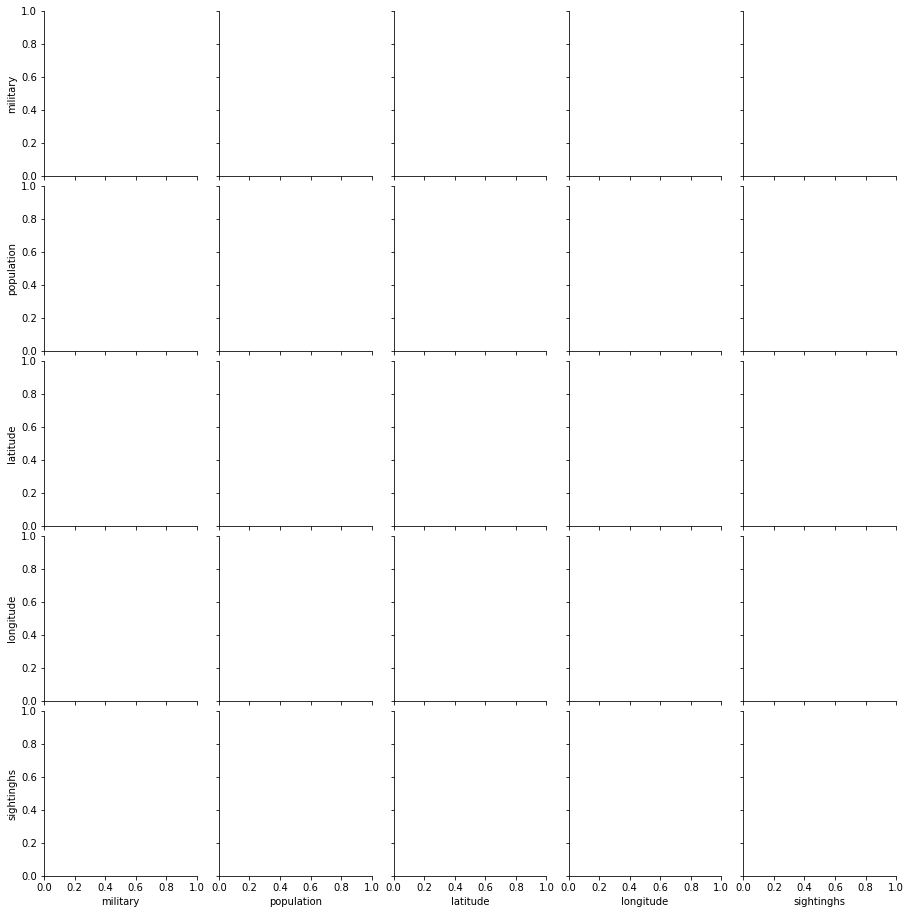

In [42]:
sns.pairplot(merged)
sns.plt.show()